<a href="https://colab.research.google.com/github/metahwi/MachineLearning/blob/main/Weather%20Forecast%20Logistic%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression


In [1]:
from google.colab import drive
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


class WeatherDataset(Dataset):
  def __init__(self, train_in, train_out):
        # Initialize data
        self.n_samples = train_in.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = train_in # size [n_samples, n_features]
        self.y_data = train_out # size [n_samples, 1]

  # support indexing such that dataset[i] can be used to get i-th sample
  def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

  # we can call len(dataset) to return the size
  def __len__(self):
      return self.n_samples

class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b

    def forward(self, x):
        y = self.linear(x)
        return y

def process_csv(filename):
  drive.mount('/content/drive')
  df = pd.read_csv(filename)

  # Filter data and apply normalization
  df = df.dropna()
  datatensor = torch.tensor(df.values[1:,1::].astype(float))
  datatensor = torch.nn.functional.normalize(datatensor)

  # Randomly select 80% of the examples for training,
  # remaining 20% will be for testing
  train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
  traindata = torch.stack([t for t in train])
  testdata = torch.stack([t for t in test])

  # We can create separate tensors to input and output to the model
  train_in = torch.cat([traindata[:,0:2], traindata[:,3::]], dim=1)
  test_in = torch.cat([testdata[:,0:2], testdata[:,3::]], dim=1)
  train_out = traindata[:,2].unsqueeze(1) # we will use 3rd column as target prediction
  test_out = testdata[:,2].unsqueeze(1)
  return train_in, train_out, test_in, test_out


def train(model, loss, optimizer, \
          trainingData, \
          learning_rate, steps, batch_size):

  loader = iter(DataLoader(dataset=trainingData, batch_size=batch_size, shuffle=True))

  losses = []; step = 0
  for step in range(0, steps):
    input, target = next(loader)
    optimizer.zero_grad() # reset gradiant value to zero
    model.double()
    output = model(input) # pass input to model
    err = loss(output, target) # compute mean squared error between model prediction and target value
    losses.append(err) # store err value to monitor training

    err.backward() # evaluate the gradient
    optimizer.step() # propagate the evaluated gradient to update parameters

    #print('step {}, loss {}'.format(step, err.item()))
  return losses

if __name__ == '__main__':
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.01
  steps = 100
  batch_size = 256

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

Mounted at /content/drive


FileNotFoundError: ignored

## Exercise 1

Using the provided example, plot 9 different plots for the model learning curves by ranging the batchsize in range $\{32, 64, 128\}$, and the learning rate in range $\{0.005, 0.01, 0.05\}$. At each time, observe and comment on how the change of hyperparameter affects different properties of the learning curve (e.g. the shape, the smoothness or sharpness).

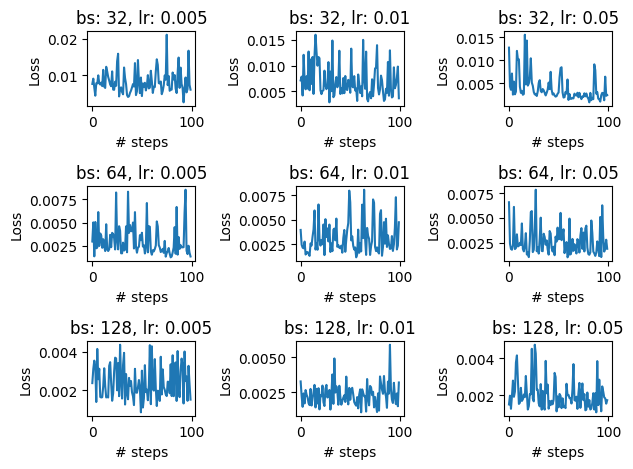

In [ ]:
## Solution ##
fig, axs = plt.subplots(3, 3)

def experiment1():

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  steps = 100

  for i, batch_size in enumerate([32, 64, 128]):
    for j, learning_rate in enumerate([0.005, 0.01, 0.05]):
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)

      axs[i][j].plot(range(steps), torch.stack(losses).detach())
      axs[i][j].set_title('bs: {}, lr: {}'.format(batch_size, learning_rate))
      axs[i][j].set_xlabel('# steps')
      axs[i][j].set_ylabel('Loss')


  plt.tight_layout()
  plt.show()

experiment1()


## Exercise 2

Implement a Python application for rain prediction in New York City using the data set and provided functions for data processing and linear regression which uses the mean absolute error as the loss function. You may use any PyTorch functions.

Mean absolute error is defined as:

$$
 MAE(x, y) = \frac{1}{n} \sum_{i=1}^n |y_i - x_i|
$$

Plot the prediction vs. actual rain measurement plots for the different models.

**Note**: Each model might have different hypermaparameters optimal for their convergence. You can use the variables $learning_rate$ and $steps$ which are inputs to the training function to tune the optimal training hyperparameters of your regression model.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.0129, dtype=torch.float64, grad_fn=<MeanBackward0>)


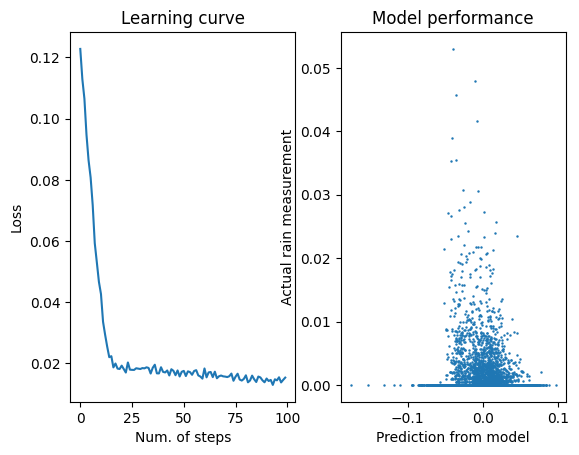

In [ ]:
## Solution ##

def experiment2():
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.005
  steps = 100
  batch_size = 256

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.L1Loss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The min. squared error in training is: ", min(losses))

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

experiment2()


## Takes from our initial experiments

1. If the model by design does not ensure a restriction on the correct range of outputs, there will be no way for the model to learn that range by itself. It will be our job as machine learning scientists to ensure that the design is consistent with the requirements of the target application from every theoretical and practical sense.
2. Repeated runs of the model may yield unstable results of the experimental settings are non-deterministic.
3. There is no one setting that works for every data set and model. Each model and data set will need its own **specific set of optimal hyper-parameters** to learn from that **specific dataset** using that **specific model**.

Rethinking our pipeline, we'll start by addressing the model design. Theoretically, the range of values of the input $x$ and output $y$ of a linear regression model

$$
  y = A*x + b
$$

is the $\mathbb{R}$.

In our application, the rain measurement values are in the range $[0, 1]$ since we have normalized them. In order to inform the model of this restriction, we can extend the model equation with an additional layer using an **activation function**.

## Logistic function

A typical function that could restrict the range of values produced by a linear projection module is the **logistic** function which takes a range of real values and transforms them into the range of values in $[0, 1]$.

$$
  \sigma (x) = \frac{e^x}{1 + e^x}
$$

(0.0, 1.0)

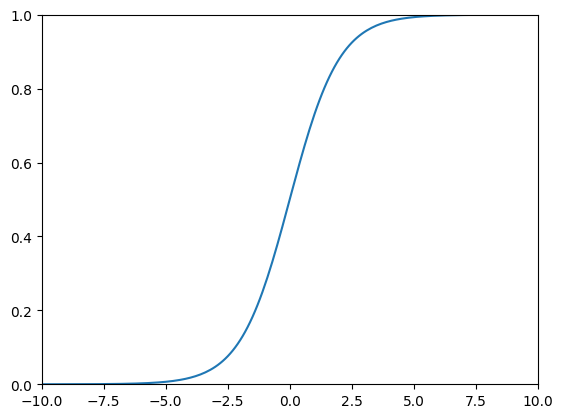

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

xi = np.arange(-10, 10, 0.1)
y = [ math.exp(x) / (1 + math.exp(x)) for x in xi]

plt.plot(xi, y)
plt.xlim(-10, 10)
plt.ylim(0, 1)


In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=True) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        y = self.linear(x)
        z = self.act(y)
        return z

We can try to test how the output range will now change.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.0063, dtype=torch.float64, grad_fn=<MseLossBackward0>)


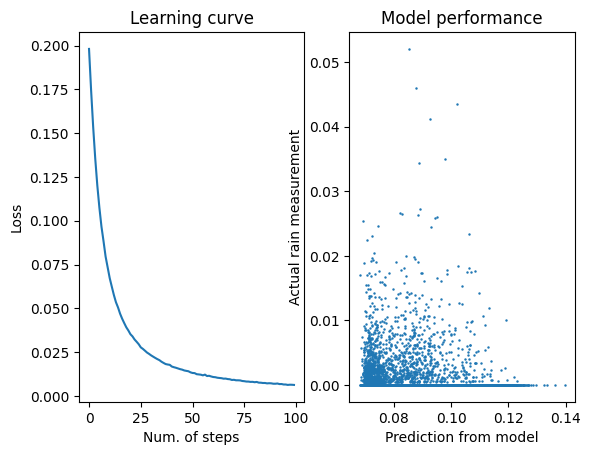

In [ ]:
def experiment3():
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.3
  steps = 100
  batch_size = 256

  model = LogisticRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The min. squared error in training is: ", min(losses))


  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

experiment3()

Note that our model has only 8 input features, thus, an 8x1 $A$ matrix for predicting the linear projection $y = A*x $ weight of each feature. If we wanted to understand how these features are weighted at each prediction, we could try to visualize their values.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv')
print(list(df.columns[1:3]) + list(df.columns[4::]))
print(model.linear.weight)

['temperature_2m (°C)', 'precipitation (mm)', 'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)']
Parameter containing:
tensor([[-0.2668, -0.1717, -0.3226,  0.0890,  0.0402,  0.2673,  0.1492, -0.0596]],
       dtype=torch.float64, requires_grad=True)


## Classification and Prediction Accuracy

A linear model with only 8 parameters may not be able to accurately model a highly complex hypothesis using an imbalanced and sparse data set. In order to ease the complexity of the task we can reduce the complexity to a **classification** task. In this case, we can still try to estimate whether or not it will rain at a given moment using our logistic model.

In [ ]:
predictions = torch.where(predictions > 0, 1.0, 0.0)
test_out = torch.where(test_out > 0, 1.0, 0.0)

print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])


Accuracy of prediction is:  tensor(0.4313)



**Accuracy** is the percentage of all correctly classified examples in our test set.  

A more refined analysis can be performed using **the confusion matrix**:
$$
C = \begin{bmatrix}
\text{Predict 0, Actual 0} & \text{Predict 0, Actual 1}\\
\text{Predict 1, Actual 0} & \text{Predict 1, Actual 1}
\end{bmatrix}
$$

Notice that the diagonal entries are the examples that are correctly classified.  

The most useful classification metrics are **Precision** and **Recall**. If we define a prediction $C_{ij}$ which belongs to class i for which we estimated the label i, we calculate them as follows.

#### Precision Score
The precision score is the percentage
$$
\text{Precision}_0 = \frac{C_{00}}{C_{00} + C_{01}}
$$

$$
\text{Precision}_1 = \frac{C_{11}}{C_{11} + C_{10}}
$$
which is the percentage of predicted rain possibility that we classify correctly.  

#### Recall Score
The recall score is the percentage
$$
\textrm{Recall}_0 = \frac{C_{00}}{C_{00} + C_{10}}
$$
$$
\textrm{Recall}_1 = \frac{C_{11}}{C_{11} + C_{01}}
$$
which is the percentage of rain possibility that we classify correctly. Note that Precision and Recall are two different quantities.

**Using multiple evaluation metrics helps give a better picture of how well our classifier is doing.**

Using the different features in the weather measurement data set, train an individual logistic regression model on each of the individual measurements:
- 'temperature_2m (°C)'
- 'precipitation (mm)'
- 'cloudcover (%)'
- 'windspeed_10m (km/h)'
- 'winddirection_10m (°)'

Plot the learning curve and predictions for the 5 different models each trained on a different set of measurements.
Calculate the binary rain prediction accuracy, precision and recall.

In [ ]:
def process_csv(dataset):
  ## To-do: Update to return only one-dimensional features
  ##
  ##
  ##
  return train_in, train_out, test_in, test_out

def exercise1():
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.3
  steps = 100
  batch_size = 256

  model = LogisticRegression(inputSize=1, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The min. squared error in training is: ", min(losses))

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

  # To-do: Compute accuracy, precision, recall

exercise1()

## Optimization

While the model design and parameter space are important to be able to accurately learn a representative hypothesis to predict a given task, the method which we use for approximating the optimal values also play an important role in the final prediction accuracy and the stability of the model runs at different trials.

The gradient descent algorithm helps minimize a loss function by computing the gradients and using their values on the trainig samples to update the model parameters. For an exact computation, the original gradient descent algorithm iterates over the entire training set and evaluates the gradient of the loss function over these input values $x$ and correct output values $y$, then uses the value for the weight $w$ update as follows.

$$
  \textrm{Compute the gradient: } g_t = - \frac{1}{N}\sum_{n=1}^N \frac{y^nx^n}{1 + e^{y^nw^T(t)x^n}}
$$

$$
  \textrm{Update the weights: } w_{t+1} = w_t + \rho g_t
$$

Note that the sign of $g_t$ would change in the equation according to an increase or decrease in the loss.

## Logistic Regression

Implement the logistic regression model on the weather prediction data set. Instead of the PyTorch SGD optimizer, create a function which implements weight update using PyTorch autograd. Plot the learning curve and predictions. Calculate the prediction accuracy, precision and recall.

In [ ]:
from torch import autograd

def update_parameters(train_in, train_out):
  ## Update to do parameter update with gradient descent
  ##
  ##
  ##
  return train_in, train_out, test_in, test_out

def exercise2():
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)

  learning_rate = 0.3
  n_iters = 100

  for ni in range(n_iters):
    update_parameters(learning_rate)
    print("The min. squared error in training is: ", min(losses))

  plt.subplot(1, 2, 1)
  plt.plot(range(n_iters), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of iterations')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

  # To-do: Compute accuracy, precision, recall

exercise2()